In [1]:
import os
import sys
import argparse
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt 

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.backends.cudnn as cudnn


from pytvision.transforms.aumentation import  ObjectImageMetadataTransform
from pytvision.transforms import transforms as mtrans

sys.path.append('../')
from torchlib.datasets import tgsdata
from torchlib.datasets.tgsdata import TGSDataset
from torchlib.datasets.imageutl import TGSProvide, TGSExProvide

In [2]:
pathnamedataset  = '~/.kaggle/competitions/tgs-salt-identification-challenge'
imsize           = 101

## Train analysis

In [3]:
data  = TGSProvide.create(  pathnamedataset, sub_folder='train', train=True, files='train.csv' )
print( len(data) )

4000


In [5]:


def lincomb(im1,im2,mask,alpha=0.5):
    im = im1.copy()      
    row, col = np.where(mask != 0)
    for i in range( len(row) ):
        r,c = row[i],col[i]
        im[r,c,0] = im1[r,c,0]*(1-alpha) + im2[r,c,0]*(alpha)
        im[r,c,1] = im1[r,c,1]*(1-alpha) + im2[r,c,1]*(alpha)
        im[r,c,2] = im1[r,c,2]*(1-alpha) + im2[r,c,2]*(alpha)
    return im

def setcolor(im, mask, color):    
    tmp=im.copy()
    tmp=np.reshape( tmp, (-1, im.shape[2])  )   
    mask = np.reshape( mask, (-1,1))      
    tmp[ np.where(mask>0)[0] ,:] = color
    im=np.reshape( tmp, (im.shape)  )
    return im

def makecolormask( mask, color=[1,0,0] ):
    colormask = np.zeros( (mask.shape[0], mask.shape[1], 3) )    
    colormask = setcolor(colormask, mask, color )        
    return colormask



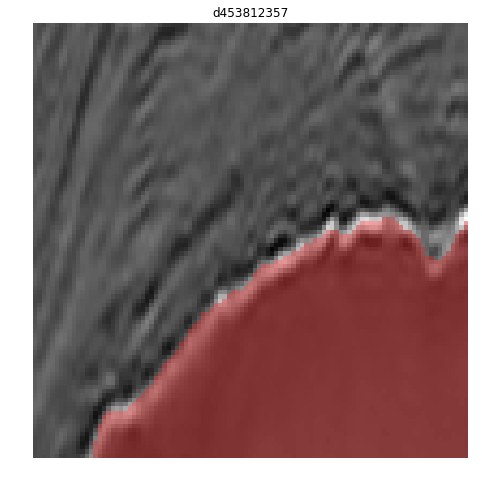

In [8]:
name, image, mask, depth = data[ np.random.randint( len(data) ) ]
colormask = makecolormask( mask, color=[1,0,0] )

plt.figure( figsize=(8,8) )
plt.imshow( lincomb( image/255, colormask, mask, alpha=0.3 ) )
#plt.imshow(image)
#plt.imshow(mask, cmap='seismic', alpha=0.2)
plt.title( name )
plt.axis('off')
plt.show()



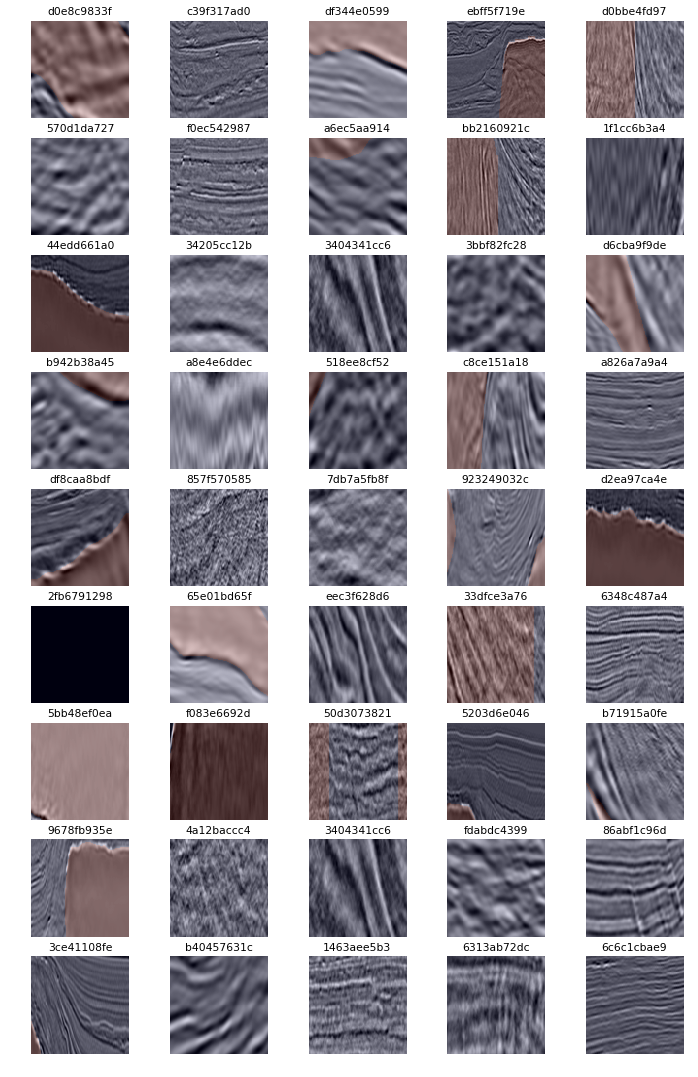

In [155]:
import matplotlib
matplotlib.rcParams['font.size'] = 9
matplotlib.rcParams['figure.figsize'] = (12,19)

numRows = 9; numCols = 5

plt.figure()
for k in range(numRows*numCols):
    idname, image, mask, depth = data[ np.random.randint( len(data) ) ]   
    plt.subplot(numRows,numCols,k+1); 
    plt.imshow(image)
    plt.imshow(mask, cmap='seismic', alpha=0.2)
    plt.title( idname ); 
    plt.axis('off')
    

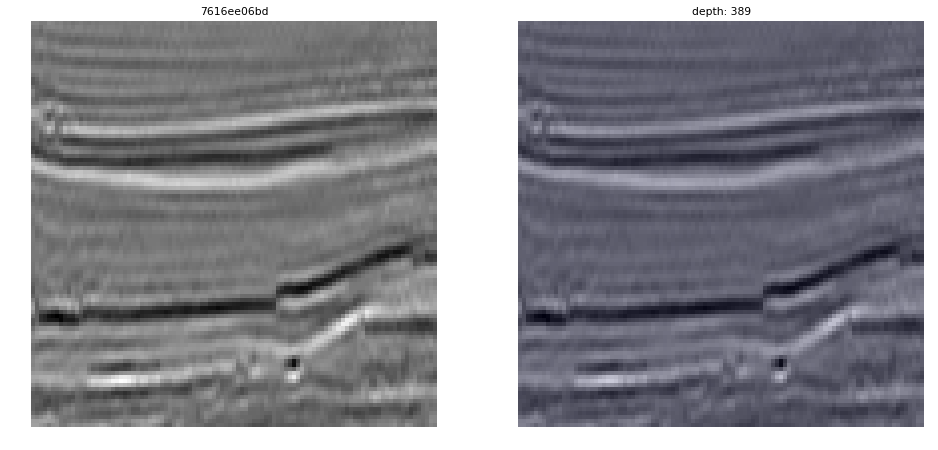

In [156]:
name, image, mask, depth = data[ np.random.randint( len(data) ) ]

plt.figure( figsize=(16,8) )
plt.subplot(121)
plt.imshow(image/255)
plt.title( name )
plt.axis('off')
plt.subplot(122)
plt.imshow(image)
plt.imshow(mask, cmap='seismic', alpha=0.2)
plt.title( 'depth: {}'.format(depth) )
plt.axis('off')
plt.show()


In [9]:
def maggradient(image):
    gI = np.gradient(image)
    divI =  (gI[0]**2 + gI[1]**2)**0.5 
    mg  = np.sum(divI>0.001)/np.prod(divI.shape)
    return mg


In [10]:

metadata = []
for i in range( len(data) ):
    name, image, mask, depth = data[ i ]
    
    mg     = maggradient(image)
    area   = mask.sum()
    mean   = image.mean()
    std    = image.std()   
    
    metadata.append( { 
        'name':name, 
        'depth':depth, 
        'mg':mg, 
        'area':area, 
        'mean':mean,
        'std':std,
        'bool': mg > 0.2 ,
        }  )
    
        
metadata = pd.DataFrame( metadata )
metadata.head()


,area,bool,depth,mean,mg,name,std
0,0,True,843,129.887364,0.999706,575d24d81d,31.135104
1,5151,True,794,113.857171,0.999804,a266a2a9df,35.468134
2,10133,True,468,83.231546,0.839918,75efad62c1,9.849187
3,1522,True,727,115.399667,0.996765,34e51dba6a,37.366145
4,437,True,797,127.167533,0.999412,4875705fb0,42.737262


In [11]:
filename=os.path.join(pathnamedataset,'metadata_train.csv')
metadata.to_csv(filename, index=None, encoding='utf-8')
print('save ...')

save ...


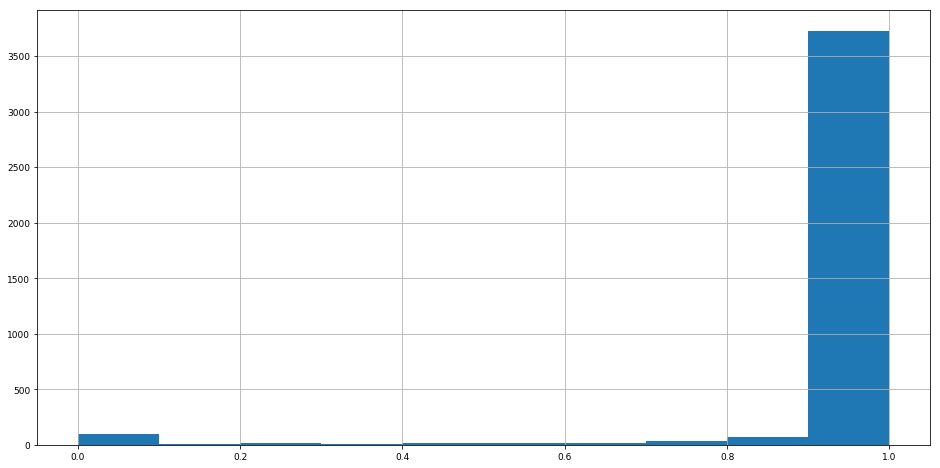

In [144]:
plt.figure( figsize=(16,8) )
metadata['mg'].hist()
plt.show()


In [187]:

index = metadata['mg'] < 0.3
areas = metadata['area'][index]

print('Total mg < 0.3:', ( index ).sum() )
print('Total no mask:', (areas>0).sum()  )

index = np.where( index )[0]


Total mg < 0.3: 121
Total no mask: 0


In [184]:

def imageshow( image, mask, metadata):
    plt.figure( figsize=(16,8) )
    plt.subplot(121)
    plt.imshow(image/255)
    plt.title( metadata['name'] )
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(image)
    plt.imshow(mask, cmap='seismic', alpha=0.2)
    plt.title( 'depth: {}'.format( metadata['depth'] ) )
    plt.axis('off')
    plt.show()


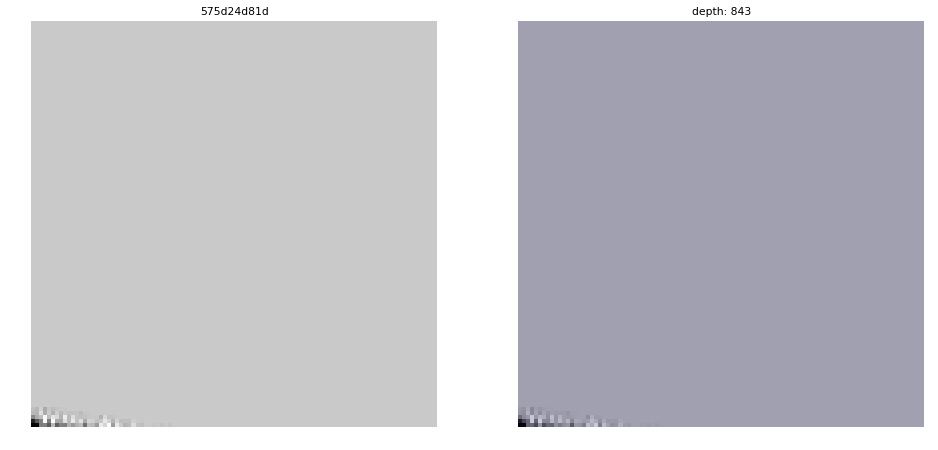

In [222]:

# for k in range( len(index) ):
k=k+1
name, image, mask, depth = data[ index[k] ]
mdata = metadata.iloc[ k ]
imageshow(image, mask, mdata )

    

## Not mask analysis

In [225]:

index = metadata['area'] == 0
print(index.sum())


1562


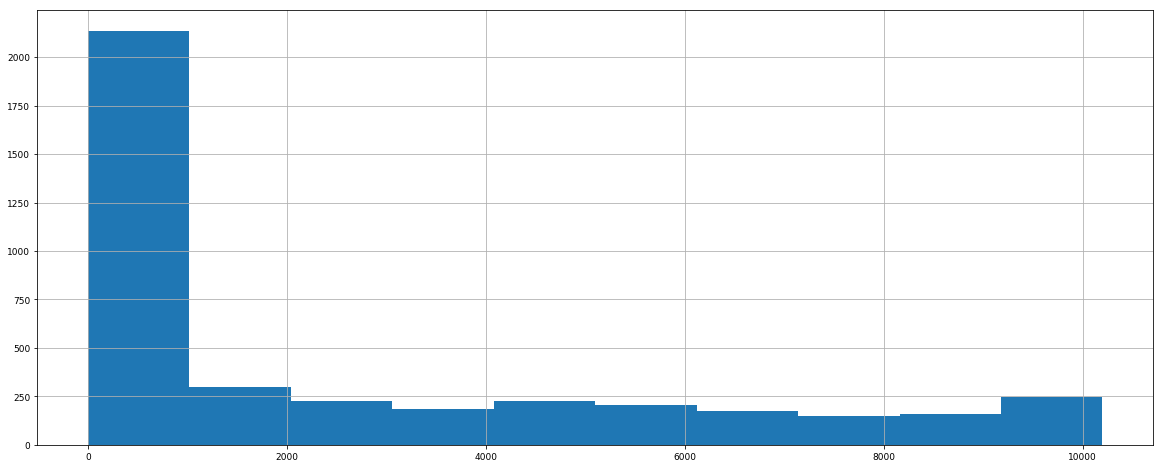

In [235]:
plt.figure( figsize=(20,8) )
metadata['area'].hist()
plt.show()

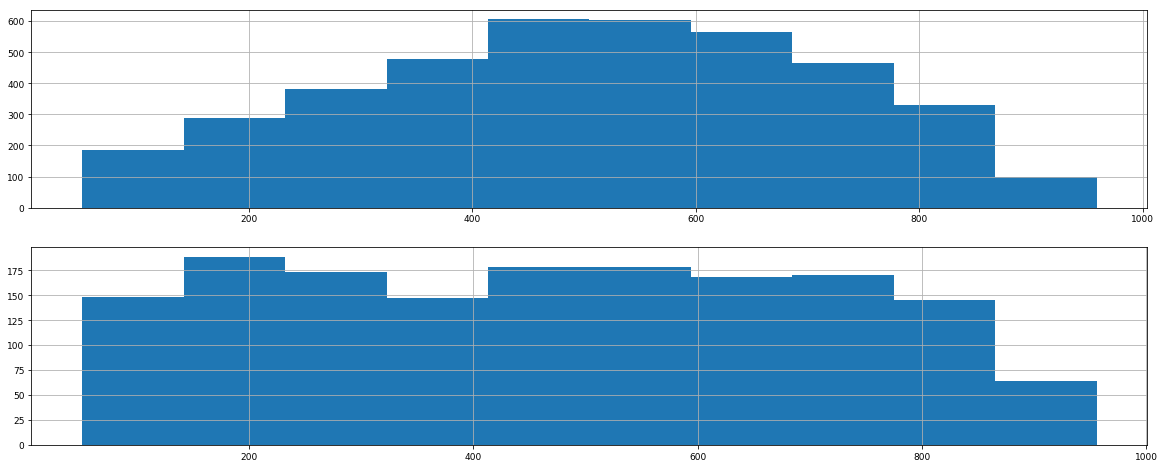

In [227]:
plt.figure( figsize=(20,8) )
plt.subplot(211)
metadata['depth'].hist()
plt.subplot(212)
metadata['depth'][index].hist()
plt.show()

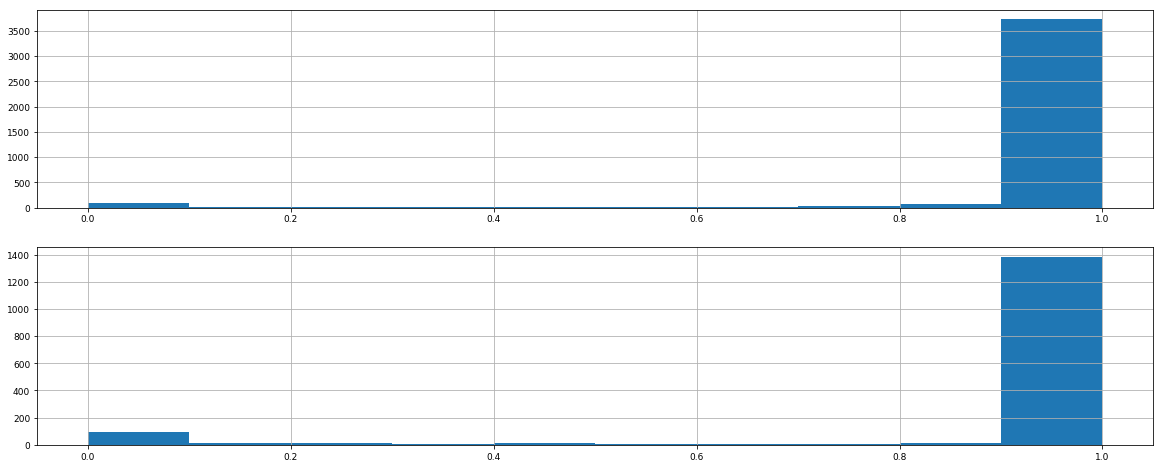

In [236]:
plt.figure( figsize=(20,8) )
plt.subplot(211)
metadata['mg'].hist()
plt.subplot(212)
metadata['mg'][index].hist()
plt.show()

## Export image for analysis

In [260]:
import scipy
from tqdm import tqdm

for i in tqdm( range(len(data)) ):
    
    name, image, mask, depth = data[ i ]
    colormask = makecolormask( mask, color=[1,0,0] )
    image_mask = lincomb( image/255, colormask, mask, alpha=0.2 )
    image_out = np.zeros( (101, 101*2+2, 3) )
    
    #image_out = np.concatenate( [image/255, image_mask], axis=1 )
    image_out[:,:101,:] = image/255
    image_out[:,101+2:,:] = image_mask        
    
    #name = '{:06}_{}'.format(i,name)
    name = '{}_{}'.format(name,i)
    
    #image_out = cv2.resize( image_out, None, fx=2, fy=2 )
    scipy.misc.imsave( '../out/dataanalyses/{}.jpg'.format(name), image_out )

#     plt.figure( figsize=(8,8) )
#     plt.imshow( image_out )
#     #plt.imshow(image)
#     #plt.imshow(mask, cmap='seismic', alpha=0.2)
#     plt.title( name )
#     plt.axis('off')
#     plt.show()

    

100%|██████████| 4000/4000 [01:23<00:00, 47.79it/s]


## Explore test dataset

In [275]:
data  = TGSProvide.create(  pathnamedataset, sub_folder='test', train=False, files='sample_submission.csv' )
print( len(data) )

18000


In [276]:
metadata = []
for i in range( len(data) ):
    name, image, depth = data[ i ]
    
    mg     = maggradient(image)
    mean   = image.mean()
    std    = image.std()   
    
    metadata.append( { 
        'name':name, 
        'depth':depth, 
        'mg':mg, 
        'mean':mean,
        'std':std,
        'bool':True,
        }  )
    
        
metadata = pd.DataFrame( metadata )
metadata.head()

,bool,depth,mean,mg,name,std
0,True,559,183.214783,0.857171,155410d6fa,26.291640
1,True,298,148.774042,0.994902,78b32781d1,22.577328
2,True,392,110.735712,0.992060,63db2a476a,16.901925
3,True,698,153.652289,0.985590,17bfcdb967,21.264970
4,True,837,109.012548,0.999706,7ea0fd3c88,29.711485


In [268]:
filename=os.path.join(pathnamedataset,'metadata_test.csv')
metadata.to_csv(filename, index=None, encoding='utf-8')
print('save ...')

save ...


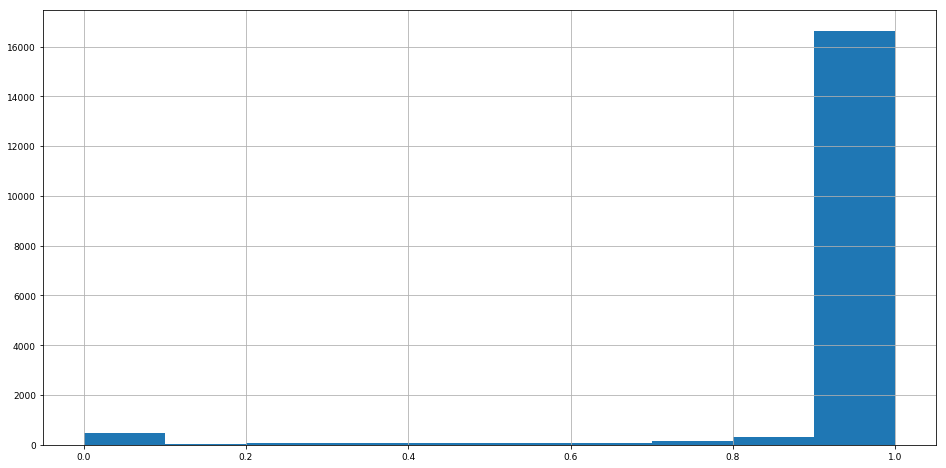

In [277]:
plt.figure( figsize=(16,8) )
metadata['mg'].hist()
plt.show()


In [293]:
index = metadata['mg'] < 0.1
print('Total mg < 0.3:', ( index ).sum() )

index = np.where( index )[0]

Total mg < 0.3: 482


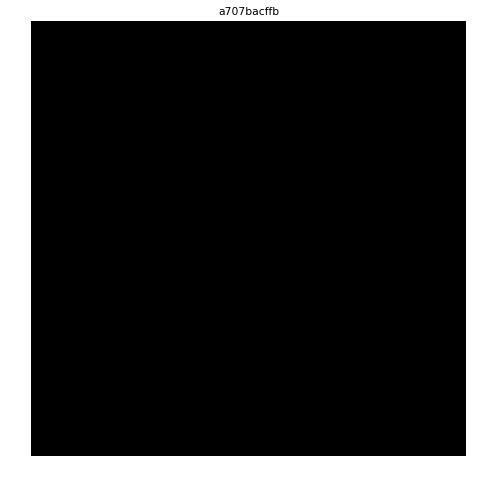

In [330]:
# for k in range( len(index) ):
k=k+1
name, image, depth = data[ index[k] ]
mdata = metadata.iloc[ k ]

plt.figure( figsize=(16,8) )
plt.imshow(image/255)
plt.title( mdata['name'] )
plt.axis('off')
plt.show()

In [3]:
data  = TGSExProvide.create(  pathnamedataset, sub_folder='train', train=True, files='train.csv', metadata='metadata_train.csv' )
print( len(data) )

3894


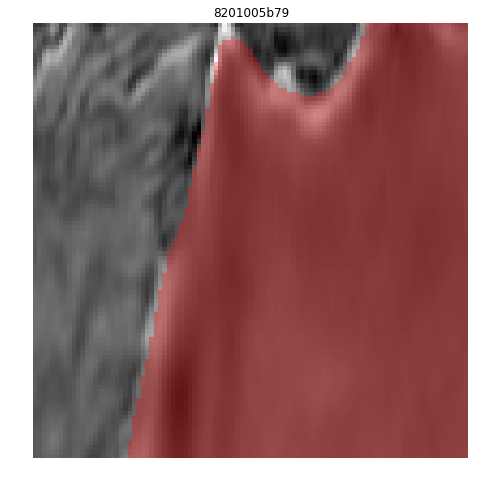

In [6]:
name, image, mask, depth = data[ np.random.randint( len(data) ) ]
colormask = makecolormask( mask, color=[1,0,0] )

plt.figure( figsize=(8,8) )
plt.imshow( lincomb( image/255, colormask, mask, alpha=0.3 ) )
#plt.imshow(image)
#plt.imshow(mask, cmap='seismic', alpha=0.2)
plt.title( name )
plt.axis('off')
plt.show()

In [7]:

metadata = []
for i in range( len(data)):
    mdata = data.getmetadata(i)
    metadata.append(mdata)
    
metadata = pd.DataFrame( metadata )
metadata.head()

,depth,mg,name
0,843,0.999706,575d24d81d
1,794,0.999804,a266a2a9df
2,468,0.839918,75efad62c1
3,727,0.996765,34e51dba6a
4,797,0.999412,4875705fb0


In [8]:
index = metadata['mg'] < 0.1
print('Total mg < 0.3:', ( index ).sum() )

index = np.where( index )[0]

Total mg < 0.3: 0


In [25]:
data  = TGSExProvide.create(  pathnamedataset, sub_folder='test', train=False, files='sample_submission.csv', metadata='metadata_test.csv' )
print( len(data) )

18000


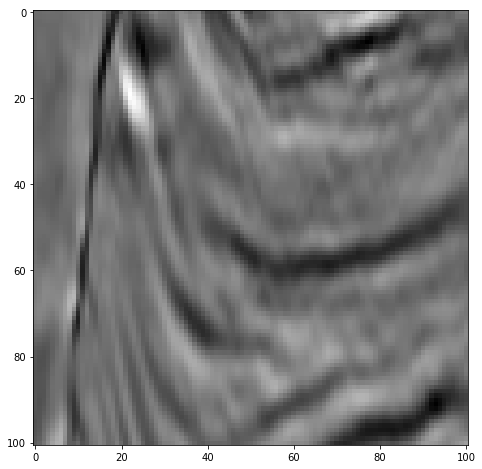

In [26]:
name, image, depth = data[ np.random.randint( len(data) ) ]

plt.figure(figsize=(8,8))
plt.imshow(image)
plt.show()
